In [2]:
import re
import operator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from collections import Counter
from scipy.sparse import csr_matrix
from pandas.api.types import is_numeric_dtype

from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

# **LOADING AND CHECKING THE DATA**

In [3]:
books = pd.read_csv("../dataset/Books.csv")
users = pd.read_csv("../dataset/Users.csv")
ratings = pd.read_csv("../dataset/Ratings.csv")

print("BOOKS - ", books.shape)
print("USERS - ", users.shape)
print("RATINGS - ", ratings.shape)

BOOKS -  (271360, 8)
USERS -  (278858, 3)
RATINGS -  (1149780, 3)


# **PREPROCESSING** 

In [4]:
# dropping the URL columns
books.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [5]:
# checking for null values
books.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
dtype: int64

In [6]:
# we check for missing author names
books.loc[books['Book-Author'].isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing


In [7]:
# we check for missing publisher names
books.loc[books['Publisher'].isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


In [8]:
# filling those missing values
books.at[187689 ,'Book-Author'] = 'Other'
books.at[128890 ,'Publisher'] = 'Other'
books.at[129037 ,'Publisher'] = 'Other'

In [9]:
# checking for column Year-of-publication
books['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

In [10]:
# uppercasing all the ISBN alphabets
books['ISBN'] = books['ISBN'].str.upper()

In [11]:
# dropping duplicate rows
books.drop_duplicates(keep='last', inplace=True) 
books.reset_index(drop = True, inplace = True)
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271166 entries, 0 to 271165
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271166 non-null  object
 1   Book-Title           271166 non-null  object
 2   Book-Author          271166 non-null  object
 3   Year-Of-Publication  271166 non-null  object
 4   Publisher            271166 non-null  object
dtypes: object(5)
memory usage: 10.3+ MB


In [12]:
print("Columns: ", list(users.columns))
users.head()

Columns:  ['User-ID', 'Location', 'Age']


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [13]:
# checking the null values
print(users.isna().sum())               

User-ID          0
Location         0
Age         110762
dtype: int64


In [14]:
# the values present in Age column
print(sorted(list(users['Age'].unique())))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

In [15]:
# we will be replacing outliers and null values with the mean
required = users[users['Age'] <= 80]
required = required[required['Age'] >= 10]
mean = round(required['Age'].mean())   
mean

35

In [16]:
users.loc[users['Age'] > 80, 'Age'] = mean    # the outliers with age greater than 80 are replaced with mean 
users.loc[users['Age'] < 10, 'Age'] = mean    # the outliers with age less than 10 years are replaced with mean
users['Age'] = users['Age'].fillna(mean)      # we will be filling null values with mean
users['Age'] = users['Age'].astype(int)

In [17]:
# ratings columns
print("Columns: ", list(ratings.columns))
ratings.head()

Columns:  ['User-ID', 'ISBN', 'Book-Rating']


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [18]:
# checking for null values
ratings.isnull().sum() 

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [19]:
# checking ISBN
flag = 0
k =[]
reg = "[^A-Za-z0-9]"

for x in ratings['ISBN']:
    z = re.search(reg,x)    
    if z:
        flag = 1

if flag == 1:
    print("False")
else:
    print("True")

False


In [20]:
# uppercasing all the lowercase alphabets in the ISBN
ratings['ISBN'] = ratings['ISBN'].str.upper()

In [21]:
# dropping duplicate rows
ratings.drop_duplicates(keep='last', inplace=True)
ratings.reset_index(drop=True, inplace=True)

In [22]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


# **MERGING THE TABLES**

In [23]:
dataset = pd.merge(books, ratings, on='ISBN', how='inner')
dataset = pd.merge(dataset, users, on='User-ID', how='inner')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1035693 entries, 0 to 1035692
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   ISBN                 1035693 non-null  object
 1   Book-Title           1035693 non-null  object
 2   Book-Author          1035693 non-null  object
 3   Year-Of-Publication  1035693 non-null  object
 4   Publisher            1035693 non-null  object
 5   User-ID              1035693 non-null  int64 
 6   Book-Rating          1035693 non-null  int64 
 7   Location             1035693 non-null  object
 8   Age                  1035693 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 79.0+ MB


In [24]:
# explicit ratings dataset
dataset1 = dataset[dataset['Book-Rating'] != 0]
dataset1 = dataset1.reset_index(drop = True)
dataset1.shape

(385560, 9)

In [25]:
# implicit ratings dataset
dataset2 = dataset[dataset['Book-Rating'] == 0]
dataset2 = dataset2.reset_index(drop = True)
dataset2.shape

(650133, 9)

# **VISUALIZING THE DATA**

Text(0.5, 1.0, 'Number of books')

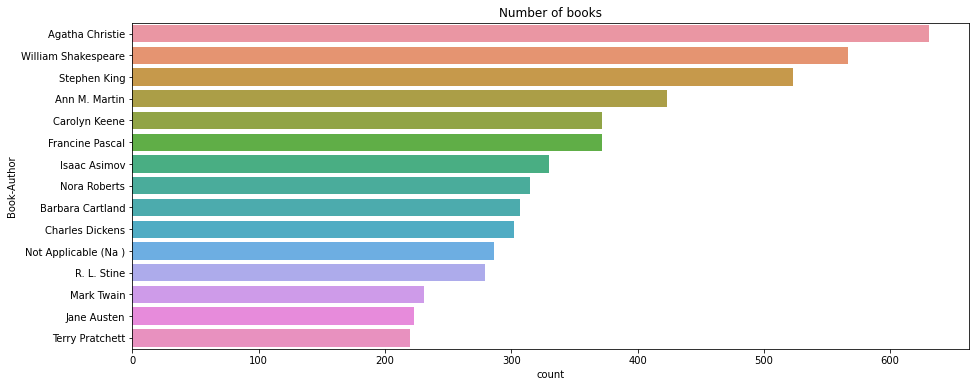

In [26]:
plt.figure(figsize=(15,6))
sns.countplot(y="Book-Author", data=books,order=books['Book-Author'].value_counts().index[0:15])
plt.title("Number of books")

Text(0.5, 1.0, 'Graph of Explicit Ratings')

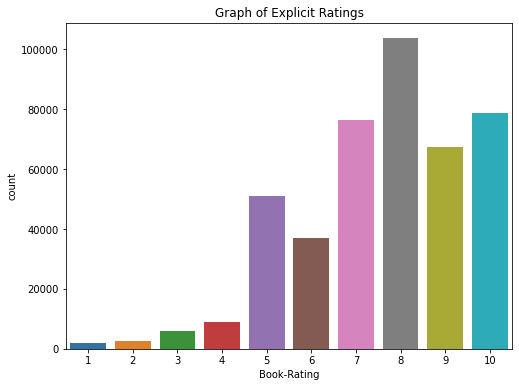

In [27]:
# explicit ratings for the books
plt.figure(figsize=(8,6))
data = ratings[ratings['Book-Rating'] != 0]
sns.countplot(x="Book-Rating", data=data)
plt.title("Graph of Explicit Ratings")

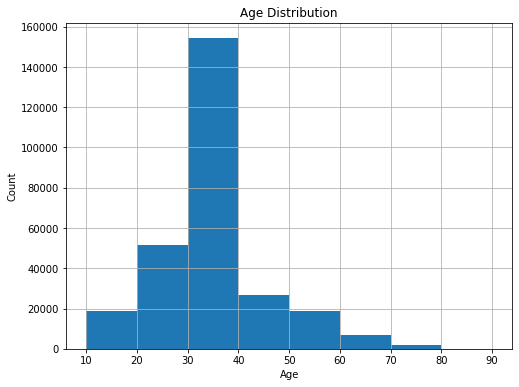

In [28]:
plt.figure(figsize=(8,6))
users.Age.hist(bins=[10*i for i in range(1, 10)])     
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# **IMPLEMENTING THE RECOMMENDATION SYSTEMS**

In [2]:
bookName = input("NAME OF THE BOOK : ")
number = int(input("NUMBER OF RECOMMENDATIONS DESIRED : "))

# 1. POPULARITY BASED RECOMMENDATION SYSTEM

For this, we will be listing the top 50 most popular books.

In [ ]:
ratings_book_name = ratings.merge(books, on='ISBN')
ratings_book_name.head(1)

In [ ]:
number_ratings = ratings_book_name.groupby('Book-Title').count()['Book-Rating'].reset_index()
number_ratings.rename(columns={'Book-Rating':'Number-of-Ratings'},inplace = True)
number_ratings

In [ ]:
average_ratings = ratings_book_name.groupby('Book-Title').mean()['Book-Rating'].reset_index()
average_ratings.rename(columns={'Book-Rating':'Average-Rating'},inplace = True)
average_ratings

In [ ]:
pop_df = number_ratings.merge(average_ratings, on='Book-Title')
pop_df

In [ ]:
pop_df = pop_df[pop_df['Number-of-Ratings']>=300].sort_values('Average-Rating', ascending = False)
pop_df = pop_df.head(50)
pop_df = pop_df.merge(books, on='Book-Title').drop_duplicates('Book-Title')[['Book-Title', 'Book-Author', 'Number-of-Ratings', 'Average-Rating']]
pop_df

Those are the top 50 most popular books!

# 2. USER BASED COLLABORATIVE FILTERING

In [ ]:
x = ratings_book_name.groupby('User-ID').count()['Book-Rating'] > 250 # avid readers 
avid_readers = x[x].index

In [ ]:
filtered = ratings_book_name[ratings_book_name['User-ID'].isin(avid_readers)]

In [ ]:
known = filtered.groupby('Book-Title').count()['Book-Rating'] >= 50
popular = known[known].index
final = filtered[filtered['Book-Title'].isin(popular)]

In [ ]:
df = final.pivot_table(index = 'Book-Title', columns = 'User-ID', values = 'Book-Rating')
df.fillna(0,inplace=True)
df

In [ ]:
similarity = cosine_similarity(df) # cosine similarity

In [ ]:
def recommend(book_name):
    index = np.where(df.index == book_name)[0][0]
    enum_list = list(enumerate(similarity[index]))
    similar_items = sorted(enum_list, key=lambda x:x[1], reverse=True)[1:6]
    for i in similar_items:
        print(df.index[i[0]])
    distance = similarity[index]
#     return suggestion using cosine similarity
recommend(bookName)

# 3. ITEM BASED FILTERING SYSTEM

In [ ]:
temp_df = books.merge(ratings, how='left', on='ISBN')
final_df = temp_df.merge(users, how='left', on='User-ID')
final_df.shape

In [ ]:
final_df.dropna(inplace=True)
final_df['User-ID'] = final_df['User-ID'].astype('int')
final_df=final_df[final_df["Book-Rating"]>0]
final_df.groupby('Book-Author')['ISBN'].agg('count').sort_values(ascending=False)

In [ ]:
final_df.groupby('ISBN').agg({'Book-Title':'count'}).sort_values(by='Book-Title',ascending=False).head(100)

In [ ]:
final_df.groupby('User-ID')['Book-Rating'].agg('count').sort_values(ascending=False)

In [ ]:
rating_book = pd.DataFrame(final_df['Book-Title'].value_counts())
final_df['Book-Title'].value_counts().mean() # 2.4688

rare_books = rating_book[rating_book['Book-Title'] <= 50].index

common_books = final_df[~final_df["Book-Title"].isin(rare_books)]
common_books['Book-Title'].value_counts().mean() 

In [ ]:
# creating the user-item matrix
user_book_matrix = common_books.pivot_table(index=['User-ID'], columns=['Book-Title'], values='Book-Rating')
user_book_matrix.shape

In [ ]:
book_name = bookName
def book_to_ISBN(name):
    """
    This function gives us the ISBN number of the book for the name of the book which you want to learn ISBN number.
    :param name: the name of the book
    :return: ISBN; the books are identified by their respective ISBN
    """
    ISBN = final_df[final_df['Book-Title'] == name][['ISBN']].iloc[0,0]
    return ISBN

ISBN_no = book_to_ISBN(book_name)

book_df = user_book_matrix[book_name]
book_df.sort_values(ascending=False)

In [ ]:
similar_to_book_name = user_book_matrix.corrwith(book_df)

corr_book_name = pd.DataFrame(similar_to_book_name, columns=['Correlation'])
corr_book_name.dropna(inplace=True)
corr_book_name.sort_values(by='Correlation',ascending=False).head(50)

In [ ]:
recommended_list = corr_book_name.reset_index().sort_values(by=('Correlation'),ascending=False)['Book-Title'].head(number+1).to_list()
recommended_list

# 4. CONTENT BASED FILTERING SYSTEM

In [ ]:
df = pd.DataFrame(dataset1['Book-Title'].value_counts())
df['Total-Ratings'] = df['Book-Title']
df['Book-Title'] = df.index
df.reset_index(level=0, inplace=True)
df = df.drop('index',axis=1)

df = dataset1.merge(df, left_on = 'Book-Title', right_on = 'Book-Title', how = 'left')
df = df.drop(['Year-Of-Publication','Publisher','Age'], axis=1)

In [ ]:
popularity_threshold = 80
popular_book = df[df['Total-Ratings'] >= popularity_threshold]
popular_book = popular_book.reset_index(drop = True)
popular_book.shape

In [ ]:
tf = TfidfVectorizer(ngram_range=(1, 2), min_df = 1, stop_words='english')
tfidf_matrix = tf.fit_transform(popular_book['Book-Title'])
tfidf_matrix.shape

In [ ]:
normalized_df = tfidf_matrix.astype(np.float32)
cosine_similarities = cosine_similarity(normalized_df, normalized_df)
cosine_similarities.shape

In [ ]:
isbn = books.loc[books['Book-Title'] == bookName].reset_index(drop = True).iloc[0]['ISBN']
content = []

idx = popular_book.index[popular_book['ISBN'] == isbn].tolist()[0]
similar_indices = cosine_similarities[idx].argsort()[::-1]
similar_items = []
for i in similar_indices:
    if popular_book['Book-Title'][i] != bookName and popular_book['Book-Title'][i] not in similar_items and len(similar_items) < number:
        similar_items.append(popular_book['Book-Title'][i])
        content.append(popular_book['Book-Title'][i])

for book in similar_items:
    print(book)